<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#코인판-크롤러-프로그램" data-toc-modified-id="코인판-크롤러-프로그램-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>코인판 크롤러 프로그램</a></span><ul class="toc-item"><li><span><a href="#크롤링-프로그램" data-toc-modified-id="크롤링-프로그램-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>크롤링 프로그램</a></span></li></ul></li></ul></div>

# 코인판 크롤러 프로그램

해당 프로그램은 2022년 11월에 제작됐으며, 향후 코인판 홈페이지의 개편이나 보안 강화가 이뤄질 경우, 해당 프로그램이 작동되지 않을 수 있습니다.

In [1]:
#module import 

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt

okt = Okt()

In [2]:
plt.rcParams["font.family"] = "Hancom MalangMalang"
plt.rcParams['figure.figsize'] = 10,10
sns.set(font="Hancom MalangMalang", rc={"axes.unicode_minus":False}, style='white')

In [3]:
#function

def word_counter(value, key_words):
    for i in value:
        if i not in key_words:
            key_words[i] = 1 #최초 언어
        elif i in key_words:
            key_words[i] += 1 #중복 언어
    return key_words


def tokenizer(text):
    lis = []
    for i in text:
        word = okt.nouns(i) #토큰화
        for k in word:
            lis.append(k)
    return lis


def counter_to_DataFrame(key_words):
    word_df = pd.DataFrame(key_words.items()) #Data Frame 형성
    word_df.columns = ['단어', '빈도']
    word_df = word_df.sort_values(['빈도'],ascending = False).reset_index(drop = True) #내림차순 정렬
    return word_df


## 크롤링 프로그램
하단의 프로그램을 통해 코인판의 내용을 크롤링 할 수 있습니다

In [4]:
iter = 100   #몇 페이지까지 크롤링 할 것인지?

In [5]:
key_words = {}
word_lis = []

for i in range(iter):
    url = 'https://coinpan.com/index.php?mid=free&page=' + str(i)
    
    #딜레이 생성
    seed = np.random.randint(100)
    np.random.seed(seed)
    a = np.random.randint(5)
    time.sleep(a)

    #url 호출
    session = requests.session()
    res = session.get(url)
    res.raise_for_status()

    #html 추출
    soup = BeautifulSoup(res.text, 'html.parser')
    a = soup.find_all("td", attrs = {'class':'title'}) #제목이 들어있는 태그의 텍스트 추출
    text = str(a)
    num = len(a)
    words = re.compile('[가-힣]+').findall(text) #한글 제외 전부 제거
    words = words[25:-18] #불용어 제거
    
    token = tokenizer(words) #토큰화
    word_lis.append(token)
    key_words = word_counter(token, key_words) #Counter Dict 형성


In [6]:
df = counter_to_DataFrame(key_words) #Data Frame으로 변환
df #글, 첨부, 이미지는 불용어 --> 이는 별도로 제거

,단어,빈도
0,글,2000
1,웨이브,488
2,첨부,450
3,이미지,221
4,비트,175
...,...,...
191,마스크,1
192,금투세,1
193,젠,1
194,제일,1


In [7]:
# df = df[df["단어"].str.len()>=2].drop([1,2]) #불용어 제거
df = df.drop([0,1,2,3]) #불용어 제거
df = df[df['단어'].str.len() > 1]
df.reset_index(drop=True, inplace=True)

In [8]:
 top_df = df.head(30) #상위 20개 단어 추출

<AxesSubplot:xlabel='빈도', ylabel='단어'>

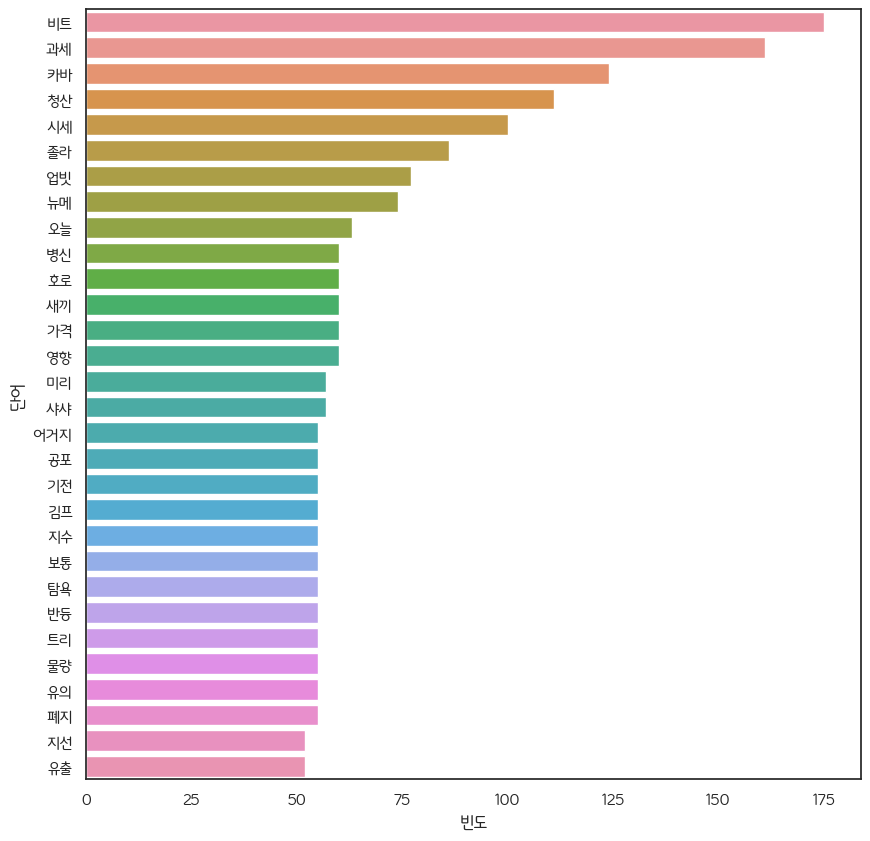

In [9]:
sns.barplot(data = top_df, x = '빈도', y = '단어')

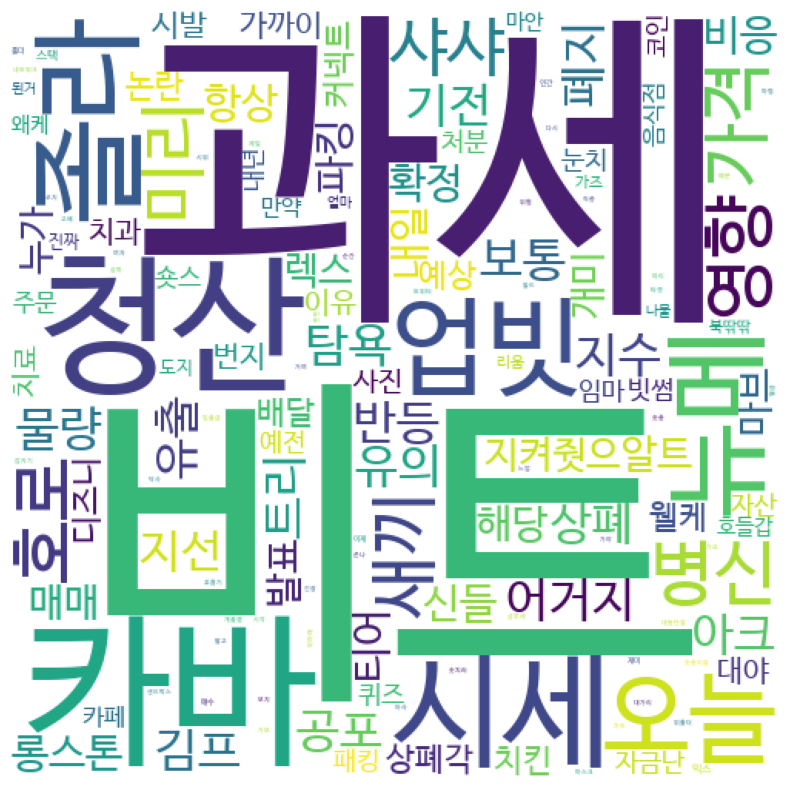

In [10]:
#WordCloud 형성
wc = WordCloud(font_path = 'C:\\Users\\cjsso\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf', #폰트 위치(사용자에 맞게 설정)
    width = 500,
    height = 500,
    background_color='white').generate_from_frequencies(df.set_index('단어').to_dict()['빈도'])


plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [37]:
for lis in word_lis:
    for i in lis:
        if not len(i) > 1:
            lis.remove(i)
    while '이미지' in lis:
        lis.remove('이미지')
    while '첨부' in lis:
        lis.remove('첨부')
    while '손흥민' in lis:
        lis.remove('손흥민')
    while '마스크' in lis:
        lis.remove('마스크')

In [38]:
word_lis

[['나중',
  '시체',
  '토스',
  '옵티미즘',
  '크게',
  '보드',
  '감독',
  '한마디',
  '조던',
  '아이유',
  '테마',
  '아이큐',
  '레퍼럴',
  '가입자',
  '손실',
  '손익',
  '위메이드',
  '제시',
  '방향',
  '시빅',
  '상폐',
  '썬더',
  '아이큐',
  '가즈',
  '백수',
  '굿모닝',
  '이노',
  '메인',
  '토큰',
  '스왑',
  '핑계',
  '스팅',
  '팀물량',
  '갑자기',
  '코인',
  '빈살',
  '최고',
  '부자',
  '역시',
  '폰지사기',
  '안휘',
  '둘리',
  '오늘',
  '코인',
  '한국',
  '축구',
  '반등',
  '세금',
  '관련',
  '카타르',
  '직관',
  '사람',
  '메인프레임',
  '아이큐',
  '물량',
  '믹스',
  '꼬라시',
  '순식간',
  '생각',
  '지금',
  '코인',
  '축구선수',
  '새끼',
  '처음',
  '시세'],
 ['나중',
  '시체',
  '토스',
  '옵티미즘',
  '크게',
  '보드',
  '감독',
  '한마디',
  '조던',
  '아이유',
  '테마',
  '아이큐',
  '레퍼럴',
  '가입자',
  '손실',
  '손익',
  '위메이드',
  '제시',
  '방향',
  '시빅',
  '상폐',
  '썬더',
  '아이큐',
  '가즈',
  '백수',
  '굿모닝',
  '이노',
  '메인',
  '토큰',
  '스왑',
  '핑계',
  '스팅',
  '팀물량',
  '갑자기',
  '코인',
  '빈살',
  '최고',
  '부자',
  '역시',
  '폰지사기',
  '안휘',
  '둘리',
  '오늘',
  '코인',
  '한국',
  '축구',
  '반등',
  '세금',
  '관련',
  '카타르',
  '직관',
  '사람',
  '메인프레임',
  '아이큐',
  '

In [39]:
from gensim import corpora
coin_dict = corpora.Dictionary(word_lis)
corpus = [coin_dict.doc2bow(text) for text in word_lis]

In [40]:
import gensim

perplexity = []
for i in range(2,30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    perplexity.append(ldamodel.log_perplexity(corpus))

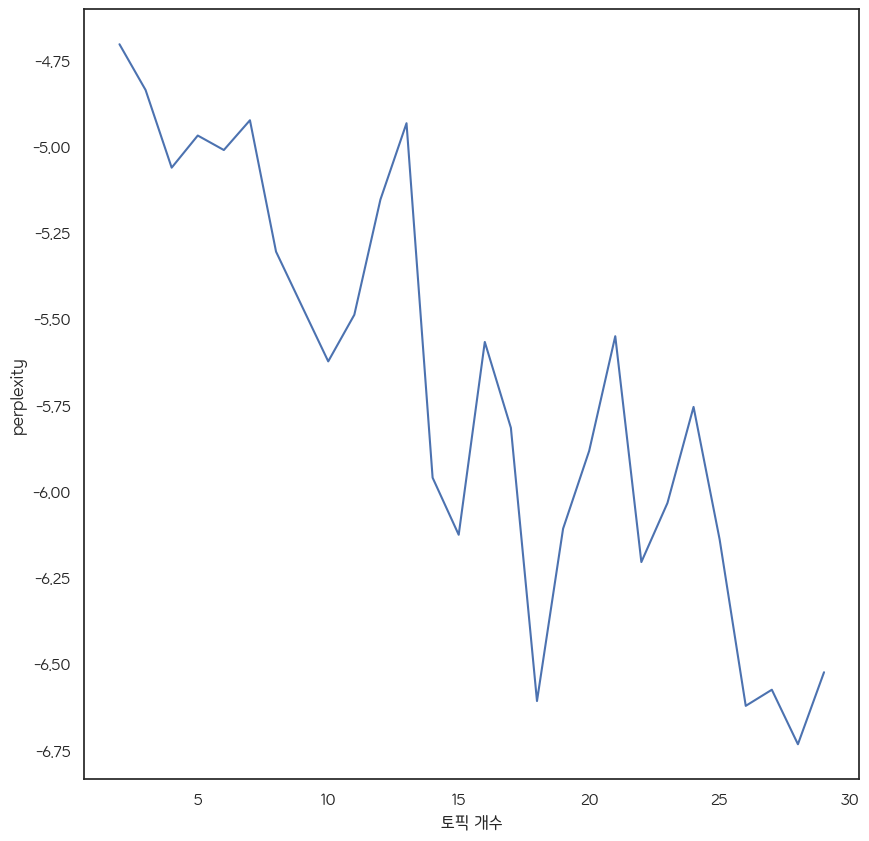

In [41]:
x = range(2,30)
plt.plot(x,perplexity)
plt.xlabel("토픽 개수")
plt.ylabel("perplexity")
plt.show()

In [42]:
from gensim.models import CoherenceModel

coherence = []
for i in range(2,30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    coherence_mo_lda = CoherenceModel(model = ldamodel, texts = word_lis, dictionary = coin_dict, topn=10) 
    coherence_lda = coherence_mo_lda.get_coherence()
    coherence.append(coherence_lda)

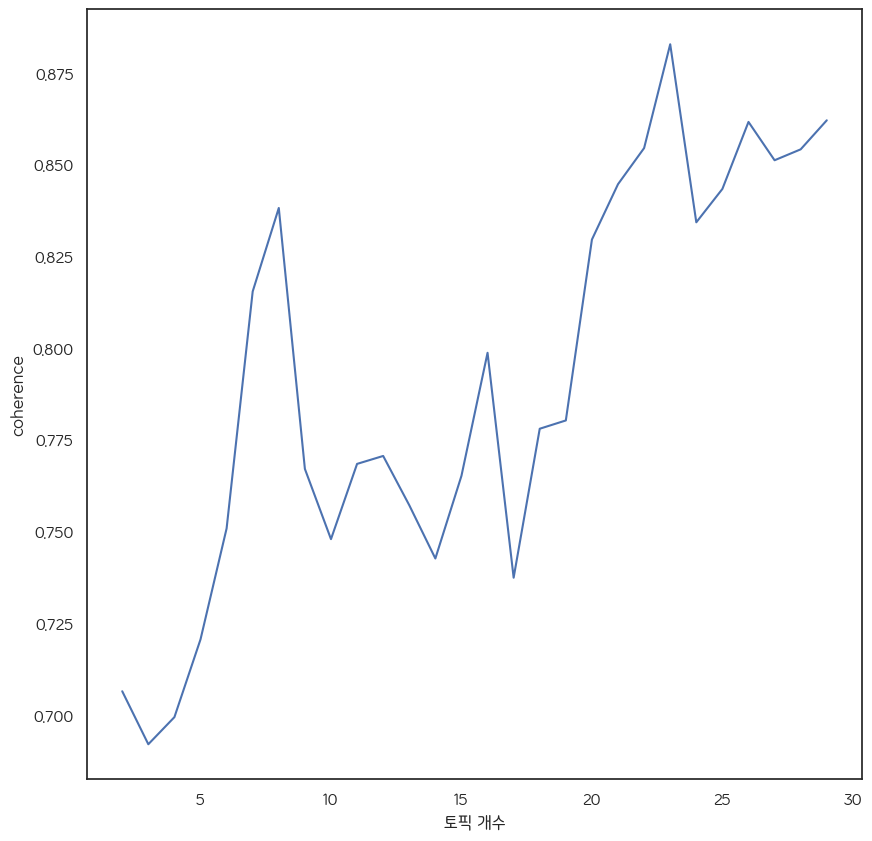

In [43]:
x = range(2,30)
plt.plot(x,coherence)
plt.xlabel("토픽 개수")
plt.ylabel("coherence")
plt.show()

In [48]:
NUM_TOPICS = 8
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=coin_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.009*"아이큐" + 0.009*"코인" + 0.009*"크게" + 0.009*"둘리" + 0.009*"빈살"')
(1, '0.009*"아이큐" + 0.009*"코인" + 0.009*"국민" + 0.009*"굿모닝" + 0.009*"가입자"')
(2, '0.009*"아이큐" + 0.009*"코인" + 0.009*"폰지사기" + 0.009*"테마" + 0.009*"물량"')
(3, '0.043*"도지" + 0.029*"어제" + 0.016*"아이큐" + 0.016*"위메이드" + 0.016*"문제"')
(4, '0.046*"아이큐" + 0.036*"코인" + 0.017*"가나" + 0.015*"팀물량" + 0.015*"사람"')
(5, '0.009*"아이큐" + 0.009*"가나" + 0.009*"코인" + 0.009*"시세" + 0.009*"국민"')
(6, '0.009*"아이큐" + 0.009*"코인" + 0.009*"가나" + 0.009*"갑자기" + 0.009*"레퍼럴"')
(7, '0.009*"아이큐" + 0.009*"코인" + 0.009*"가나" + 0.009*"크게" + 0.009*"물량"')


In [49]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, coin_dict, mds='mmds')
pyLDAvis.display(vis)

C:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [50]:
pyLDAvis.save_html(vis, 'coinpan_LDA.html') #LDAvis save